# *A Music Genre Classifier*
> By Sam Mckay & Wes Jones



For our project we decided to create a classification problem on data that we both find interesting and a concept that we believe could be useful in several circumstances, especially platforms such as Spotify or Apple Music. The classification problem that we want to tackle is classifying songs into several different genres based on features such as “acousticness”, “danceability”, “duration”, and “energy” among several others. We hope to achieve a simplistic implementation of a multiclass machine learning model that has a reasonable training time.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt




First we need to make sure that we have all of our classifiers as well as methods for cross validation and standardization of our dataset which is a collection of music with several features. We collected this data from Kaggle using this link https://www.kaggle.com/code/yashmehta648/music-genre-prediction/notebook.

In [ ]:
data = pd.read_csv('music_genre.csv')
data = data.dropna(axis=0)
data

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop


Here we read in the CSV file that contains our music data. Within our music data, there are 18 features, but not all of these are necessary or helpful for the classifiers we will create later. because of this we will need to do a bit of shaping on the dataset to get it ready for training and classification.

# Heatmap: Sam McKay
  We decided that to understand the trends of our data better it would be prudent to produce a heatmap showing the degree to which specific features are correlated.

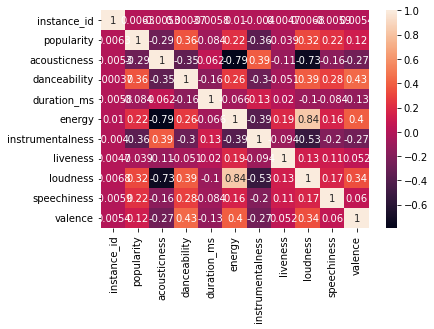

In [ ]:
plt.plot(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True)

# data_prep(): Wes Jones
In this cell, we perform the needed modification of the data. The first thing we do is drop the features that we felt won't help in classification. These features being instance_id, artist_name, track_name, obtained_data, and key. After that, we replaced Major/Minor in the mode column with 0 and 1 to clarify the data. Next, we found the NaN values in the tempo feature, replaced them with an average value, and converted them from string to float. Finally, we assigned each of the genres a number for easier classification.



In [ ]:
def data_prep(data):
  data = data.drop(['instance_id','artist_name','track_name','obtained_date', 'key'],axis=1)

  data['mode'] = data['mode'].replace({'Minor' : 0, 'Major' : 1})

  data['tempo'] = data['tempo'].replace('?',np.nan)
  data["tempo"] = data["tempo"].astype("float")
  data['tempo'] = data['tempo'].fillna(data['tempo'].mean())

  data['music_genre'] = data['music_genre'].replace({'Electronic':0, 'Anime':1, 'Jazz':2, 'Alternative':3, 'Country':4, 'Rap':5, 'Blues':6, 'Rock':7, 'Classical':8, 'Hip-Hop':9})
  return data

def SVM_Data_Prep(data):
  data = data_prep(data)
  data = data.sample(10000)
  return data

# Classifier_prep(): Sam McKay
  Since our data is so large we decided that utilizing a train/test split would be a wise decision, especially in conjunction with a cross-validation system. We turned the splitting of the data into a function since other functions need to utilize the training and test splits, otherwise we would need to pass at minimum four parameters.

In [ ]:
def classifier_prep(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, shuffle=True, random_state=43)

  return X_train, X_test, y_train, y_test

svm_data = data
svm_data = SVM_Data_Prep(svm_data) ##data sample for SVM
y = np.array(svm_data['music_genre'])
X = np.array(svm_data.drop('music_genre',axis=1))

##Get data for RF that hasn't been reduced for SVM
data = data_prep(data) ##total data for Random Forests
y_RF = np.array(data['music_genre'])
X_RF = np.array(data.drop('music_genre', axis=1))

print(X.shape)

(10000, 12)


# Baseline Classifier: Sam McKay
Within the cell below we wanted to have a baseline classifier to which we could compare the results of our other classifiers to see if our models are useful or not. We decided on using a majority classifier since it gives us good insight into the degree to which our model outperforms both a random classifier and the majority classifier since they should have roughly the same accuracy. Logically speaking a majority classifier for this dataset should have an accuracy of 10% since there are 50,000 total examples with 5,000 examples per class which is supported by the code below. Our goal is to significantly outperform this majority classifier through machine learning.

In [ ]:
X_train, X_test, y_train, y_test = classifier_prep(X,y)

y_majority = np.array(0)
y_majority = y_majority*len(y_test)

print("Majority classifier accuracy: " + str(np.mean(y_majority == y_test)))

Majority classifier accuracy: 0.10366666666666667


# SVM_creation(): Sam McKay
  Originally we planned to utilize Grid Search Cross Validation to determine which hyperparameters would be most effective in classifying our data, but upon further research into Grid Search CV, we learned that this is very computationally intensive and largely unnecessary. Instead, we use standard cross-validation with the method being KFold. This will have a significantly faster run time. We also decreased the number of Cs and the values themselves as well as the gamma values since these significantly impact the runtime. (Expect 10 min training time) We chose to use an SVM as our first classifier since SVMs can be implemented in a non-linear fashion with a tight decision boundary and because they are robust to both noise and outliers.

Non-linear SVM accuracy: [0.5475 0.54   0.5695 0.538  0.5475]
Non-linear SVM accuracy: [0.547  0.5305 0.566  0.5375 0.5515]
Non-linear SVM accuracy: [0.549  0.5275 0.565  0.539  0.551 ]


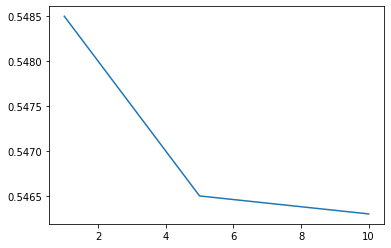

In [ ]:
C_vals = [1, 5, 10]
gamma_vals = [.0001, .001, .01]
accuracies = []

def SVM_creation(X, y, n, i):
  SVM_pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2, include_bias=False), SVC(kernel="linear", C=n, gamma=i))
  SVM_pipe.fit(X_train, y_train)

  cv = KFold(n_splits=5, random_state=42, shuffle=True)

  accuracy = cross_val_score(SVM_pipe, X, y, cv=cv, scoring='accuracy')
  print("Non-linear SVM accuracy: " + str(accuracy))
  return np.mean(accuracy)

for k in range(len(C_vals)):
  accuracies.append(SVM_creation(X, y, C_vals[k], gamma_vals[k]))


plt.plot(C_vals, accuracies)

# Random Forest: Sam McKay
  Within this function, I am creating a Random Forest Classifier since random Forests are extremely skilled with multiclass classification problems. After this I train the classifier on the training set, then I use cross-validation with a cv_method of KFold similar to the SVM function above. Using this function I can iterate over a list of estimator values to determine which number of estimators has the best speed to accuracy trade-off. After deliberating for a while we settled on using a Random Forest as our second classifier since we felt that the decision boundaries for a Random Forest would be far more appropriate for our dataset and because they have systems in place to avoid overfitting.

Accuracy with 1 estimators:
0.41112000000000004
Accuracy with 5 estimators:
0.4820399999999999
Accuracy with 10 estimators:
0.51158
Accuracy with 50 estimators:
0.5412
Accuracy with 100 estimators:
0.54464
Accuracy with 150 estimators:
0.5471199999999999


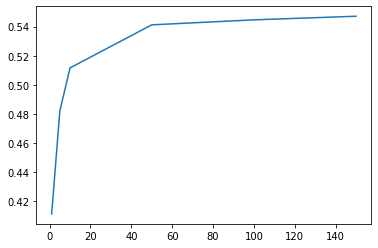

In [ ]:
estimators = [1, 5, 10, 50, 100, 150]
accuracies = []
def compute_accuracy_RF(X, y, n):
  X_train, X_test, y_train, y_test = classifier_prep(X, y)

  classifier = RandomForestClassifier(n_estimators = n)
  classifier.fit(X_train, y_train)

  cv = KFold(n_splits=5, random_state=42, shuffle=True)
  accuracy = cross_val_score(classifier, X, y, cv = cv, scoring='accuracy')
  mean_acc = np.mean(accuracy)

  print(mean_acc)
  return mean_acc

for i in estimators:
  print("Accuracy with " + str(i) + " estimators:")
  accuracies.append(compute_accuracy_RF(X_RF, y_RF, i))

plt.plot(estimators, accuracies)

# Feature Importance: Sam McKay

 Here we are seeing which of our features has the strongest bearing on our classifier. This is valuable information to understand how the Random Forest Classifier is making its decisions.

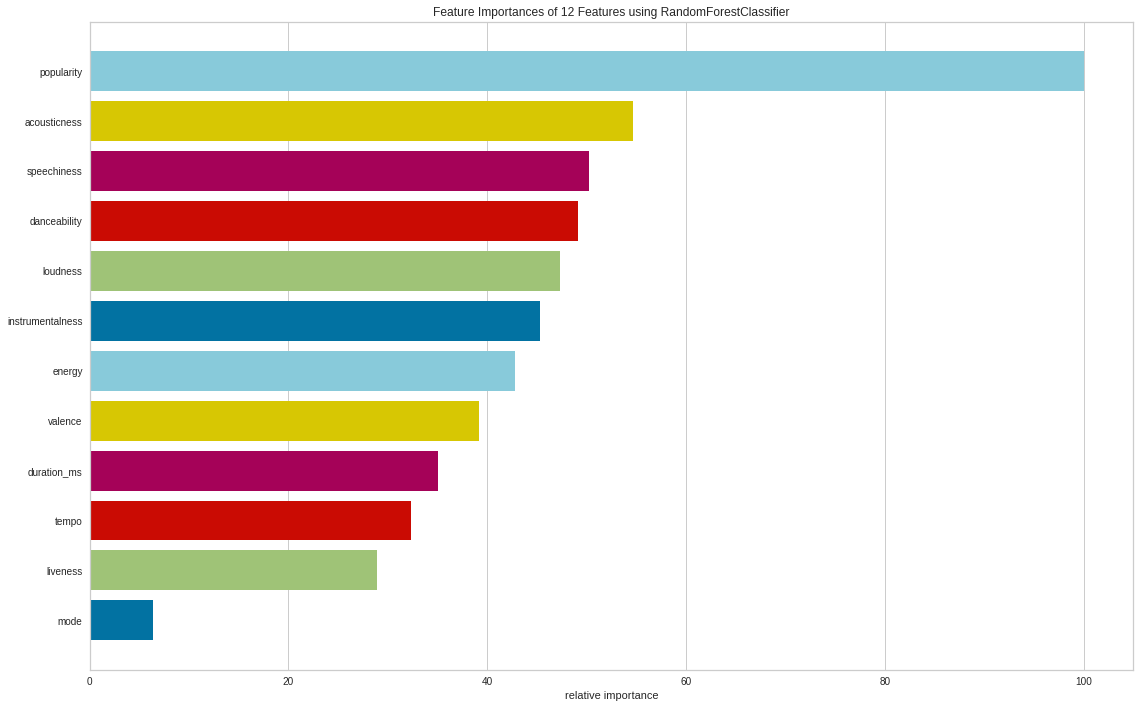

In [ ]:
from yellowbrick.model_selection import FeatureImportances

plt.figure(figsize=(16, 10))
viz = FeatureImportances(RandomForestClassifier(n_estimators=50), labels=data.columns)
viz.fit(X_RF, y_RF)
viz.show()

# visualize_classifier(): Sam McKay
  I found this code chunk within one of the Jupyter notebooks on the class GitHub. I feel that being able to visualize the data and the decision boundaries that the random forest used gives a good indication of how complex our data is and why the performance for most classifiers on this dataset have relatively low accuracy.

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=15, alpha=0.3, cmap = cmap, zorder=1)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

# PCA and visualization: Sam McKay
  I remember from class that standardizing data before performing PCA can greatly improve the results of the principal component analysis, therefore we decided to use the Standard Scaler function to standardize the data. The reason for the principal component analysis is that our data had a high dimensionality, so to visualize the data and the classifier's performance reducing that dimensionality is crucial.

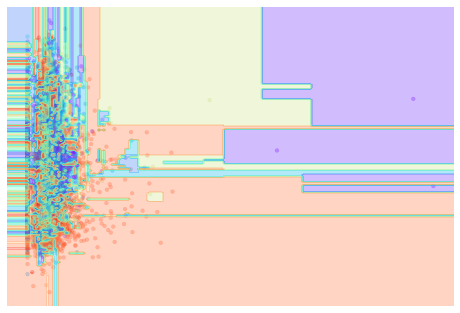

In [ ]:
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = classifier_prep(X_RF, y_RF)

rf_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 6, random_state=0))
rf_pipe.fit(X_train, y_train)

pca = PCA(2)
X_pca = pca.fit_transform(X_test)

visualize_classifier(rf_pipe, X_pca, y_test)

# Decision Tree Visualizer: Sam McKay

This brings us to our final code chunk where I discovered a function within the dtreeviz library that specializes in visualizing decision trees as the name suggests. Using the dtreeviz function I can generate the decision tree that the Random Forest Classifier uses to classify the data. Since there are 50,000 examples within our data a decision tree of that size would take an extremely long time to generate and be unreadable, so instead I took a sample of the first two genres, Electronic and Anime, just to convey the idea of a decision tree. I found this very interesting since it unmasks the complexity behind random forests and places it into a semi-readable format.

In [ ]:
!pip install dtreeviz
from dtreeviz.trees import dtreeviz

x_sample = np.array(X_RF[:10000])
y_sample = np.array(y_RF[:10000])

rf = RandomForestClassifier(n_estimators = 70)
rf.fit(x_sample, y_sample)

viz = dtreeviz(rf.estimators_[0], x_sample, y_sample, feature_names=data.columns, class_names=["Electronic", "Anime"])

viz.save("decision_tree_music.svg")

from google.colab import files
files.download("decision_tree_music.svg")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 711 kB/s 


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Analysis: Wes Jones

  After running our tests and observing the accuracies we were saddened to see we were unable to achieve the accuracy we were hoping for. The highest accuracy we were able to get was just 54%. While this was significantly better than the 10% baseline we were unhappy with its preformance. We think the reason for this low accuracy was the abstractness of the genres in the data. A good example of this was the difference between "Hip-Hop" and "Rap". While they might be two different genres, the difference is very subjective. It's impossible to draw a concrete line between the two. The same can be said for "Rock" & "Blues" and "Alternative" & "Anime". We think that the differences in these genres would not be easily distinguishable from the data we used.



  We were curious about how the number of classes in the data affected the accuracy. We decided to try and run the same tests but this time on data that only had four classes. We chose Electronic, Rap, Rock, and Classical. We chose to keep these classes because we think that these are the most distinct in the data. We were curious how our models would fair with more distinct music. We also wanted to observe how this would affect the visualizers and the feature importance.

  Below we ran the same tests with only Electronic, Rap, Rock, and Classical classes: (Code From Sam Mckay, Modified by Wes Jones)


# Data Prep: Wes Jones
In this cell we removed four of the classes using the .loc function to extract only the data we desired. And then assigned Electronic:0, Rap:1, Rock:2, Classical:3.



In [ ]:
AfterThought_data = pd.read_csv('music_genre.csv')
AfterThought_data = AfterThought_data.dropna(axis=0)

In [ ]:
def AfterThought_data_prep(data):
  data = data.copy()

  data = data.drop(['instance_id', 'artist_name', 'track_name','obtained_date', 'key'],axis=1)

  data['mode'] = data['mode'].replace({'Minor' : 0, 'Major' : 1})

  data['tempo'] = data['tempo'].replace('?',np.nan)
  data["tempo"] = data["tempo"].astype("float")
  data['tempo'] = data['tempo'].fillna(data['tempo'].mean())



  EDM = data.loc[data['music_genre'] == 'Electronic']
  Rap = Rap = data.loc[data['music_genre'] == 'Rap']
  Rock = Rock = data.loc[data['music_genre'] == 'Rock']
  Classical = Classical = data.loc[data['music_genre'] == 'Classical'] #Fix Me



  frames = [EDM, Rap, Rock, Classical]
  new_data = pd.concat(frames)
  new_data['music_genre'] = new_data['music_genre'].replace({'Electronic':0,  'Rap':1, 'Rock':2, 'Classical':3})

  return new_data

def AfterThought_SVM_Data_Prep(data):
  data = AfterThought_data_prep(data)
  data = data.sample(10000)
  return data

def AfterThought_classifier_prep(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, shuffle=True, random_state=43)

  return X_train, X_test, y_train, y_test



In [ ]:
AfterThought_svm_data = AfterThought_data
AfterThought_svm_data = AfterThought_SVM_Data_Prep(AfterThought_svm_data) ##data sample for SVM
AfterThought_y = np.array(AfterThought_svm_data['music_genre'])
AfterThought_X = np.array(AfterThought_svm_data.drop('music_genre',axis=1))
#print(AfterThought_svm_data.shape)

##Get data for RF that hasn't been reduced for SVM
data = AfterThought_data_prep(AfterThought_data) ##total data for Random Forests
AfterThought_y_RF = np.array(data['music_genre'])
AfterThought_X_RF = np.array(data.drop('music_genre', axis=1))

# SVM: Wes Jones

Non-linear SVM accuracy ( C: 1 Gamma: 0.0001 ):[0.876  0.8725 0.878  0.878  0.8775]
Non-linear SVM accuracy ( C: 5 Gamma: 0.001 ):[0.87   0.875  0.8785 0.876  0.878 ]
Non-linear SVM accuracy ( C: 10 Gamma: 0.01 ):[0.8715 0.873  0.8785 0.874  0.8785]


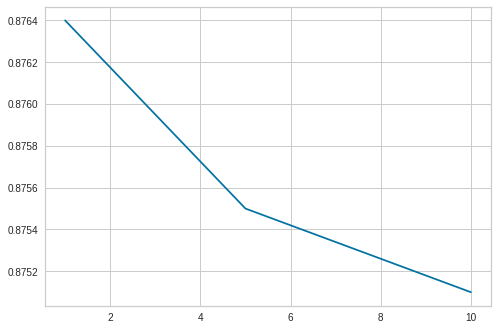

In [ ]:
AfterThought_C_vals = [1, 5, 10]
AfterThought_gamma_vals = [.0001, .001, .01]
AfterThought_accuracies = []

AfterThought_X_train, AfterThought_X_test, AfterThought_y_train, AfterThought_y_test = AfterThought_classifier_prep(AfterThought_X,AfterThought_y)

def AfterThought_SVM_creation(X, y, n, i):
  AfterThought_SVM_pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2, include_bias=False), SVC(kernel="linear", C=n, gamma=i))
  AfterThought_SVM_pipe.fit(AfterThought_X_train, AfterThought_y_train)

  AfterThought_cv = KFold(n_splits=5, random_state=42, shuffle=True)

  AfterThought_accuracy = cross_val_score(AfterThought_SVM_pipe, X, y, cv=AfterThought_cv, scoring='accuracy')
  print("Non-linear SVM accuracy (", "C:", n, "Gamma:", i, "):"  + str(AfterThought_accuracy))
  return np.mean(AfterThought_accuracy)

for k in range(len(AfterThought_C_vals)):
  AfterThought_accuracies.append(AfterThought_SVM_creation(AfterThought_X, AfterThought_y, AfterThought_C_vals[k], AfterThought_gamma_vals[k]))


plt.plot(AfterThought_C_vals, AfterThought_accuracies)


# Random Forest: Wes Jones

Accuracy with 1 estimators:
0.80085
Accuracy with 5 estimators:
0.8529
Accuracy with 10 estimators:
0.8684499999999999
Accuracy with 50 estimators:
0.88125
Accuracy with 100 estimators:
0.88125


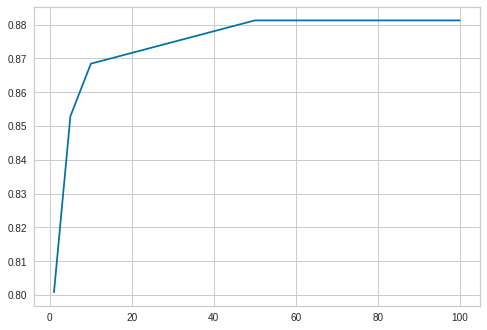

In [ ]:
AfterThought_estimators = [1, 5, 10, 50, 100]
AfterThought_accuracies = []
def AfterThought_compute_accuracy_RF(X, y, n):
  X_train, X_test, y_train, y_test = AfterThought_classifier_prep(X, y)

  classifier = RandomForestClassifier(n_estimators = n)
  classifier.fit(X_train, y_train)

  cv = KFold(n_splits=5, random_state=42, shuffle=True)
  accuracy = cross_val_score(classifier, X, y, cv = cv, scoring='accuracy')
  mean_acc = np.mean(accuracy)

  print(mean_acc)
  return mean_acc

for i in AfterThought_estimators:
  print("Accuracy with " + str(i) + " estimators:")
  AfterThought_accuracies.append(AfterThought_compute_accuracy_RF(AfterThought_X_RF, AfterThought_y_RF, i))

plt.plot(AfterThought_estimators, AfterThought_accuracies)

# Feature Importance: Wes Jones

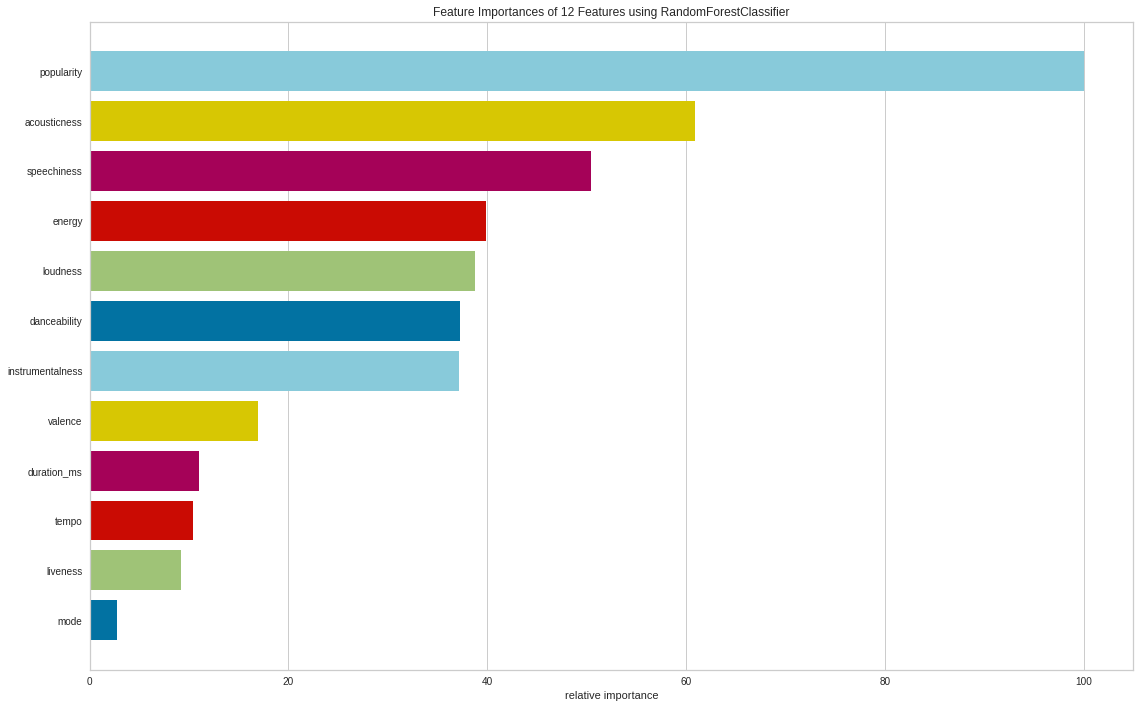

In [ ]:
from yellowbrick.model_selection import FeatureImportances

plt.figure(figsize=(16, 10))
AfterThought_viz = FeatureImportances(RandomForestClassifier(n_estimators=50),labels=data.columns)
AfterThought_viz.fit(AfterThought_X_RF, AfterThought_y_RF)
AfterThought_viz.show()

# Random Forest Visualizer: Wes Jones

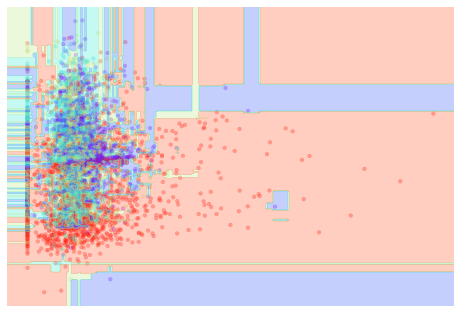

In [ ]:
from sklearn.decomposition import PCA

AfterThought_X_train, AfterThought_X_test, AfterThought_y_train, AfterThought_y_test = classifier_prep(AfterThought_X_RF, AfterThought_y_RF)

AfterThought_rf_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 6, random_state=0))
AfterThought_rf_pipe.fit(AfterThought_X_train, AfterThought_y_train)

AfterThought_pca = PCA(2)
AfterThought_X_pca = AfterThought_pca.fit_transform(AfterThought_X_test)

visualize_classifier(AfterThought_rf_pipe, AfterThought_X_pca, AfterThought_y_test)

#Conclusion: Wes Jones

After running the tests again on the data with only 4 genres we observed some interesting things
   

  One item was the Feature Importance graph. The top 4 most important features were: "popularity", "accousticness", "speechiness", and "danceability". These differed from the most important features with all 8 classes. Popularity was the best feature for both data sets. This was curious to us because popularity isn't something that a song inherently has. Popularity can differ from song to song based on what's popular in current culture. Our best guess for why this feature was so important is that the Random Forest model distinguish some genres early on from this feature. Some genres like "Rock" & "Rap" are more popular than say "Classical" and "Electronic".

  Another was the Random Forest Visualizer. The shape is very similar to the one with all the classes. But the visualizer with 4 classes looks cleaner and you can see more distinct patterns in the data.

  After cutting down the classes to four distinct genres we saw a big jump in our accuracy. Our previous model only yielded an accuracy of 54%. By making our genres more distinct we were able to up our accuracy to above 88%. This was super interesting because it showed us that songs could be categorized into genres based on the features of the data.
